# MNIST

In [45]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
# Optional
import torch_tensorrt
import tensorrt

import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
train_set = torchvision.datasets.MNIST("./datasets/", train=True, download=True)
valid_set = torchvision.datasets.MNIST("./datasets/", train=False, download=True)

In [48]:
display(train_set[0][0])

In [49]:
valid_set[0]

(<PIL.Image.Image image mode=L size=28x28>, 7)

In [50]:
input_size = 28 * 28
n_classes = 10

In [51]:
preprocess_trans = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32)
])

train_set.transform = preprocess_trans
valid_set.transform = preprocess_trans

In [52]:
base_model = nn.Sequential(
    nn.Flatten(), # Flatten 2d Tensor to 1d tensor
    nn.Linear(input_size, 2048), # 768 x 2048 input layer
    nn.ReLU(), # Activation function
    nn.Linear(2048, 2048), # 2048 x 2048 hidden layer
    nn.ReLU(), # Activation function 
    nn.Linear(2048, 1024), # 2048 x 1024 hidden layer
    nn.ReLU(), # Activation function
    nn.Linear(1024, 512), # 1024 x 512 hidden layer
    nn.ReLU(), # Activation function
    nn.Linear(512, n_classes),# 512 x 10 Output layer
) 

In [53]:
loss_function = nn.CrossEntropyLoss()

optimizer = Adam(base_model.parameters())

In [54]:
model = torch.compile(base_model.to(device))

In [ ]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=4196)
valid_loader = DataLoader(valid_set, batch_size=4196)

In [56]:
def train(epochs=20):
    train_epochLoss = []
    valid_epochLoss = []
    
    for epoch in range(epochs):
        train_stepLoss = []
        valid_stepLoss = []
        # Train step
        model.train()
        for x, y in train_loader:
            # Move both tensors to device
            x = x.to(device)
            y = y.to(device)
            # Feed forward
            output = model(x)
            # Clear gradients
            optimizer.zero_grad()
            # Calculate Loss
            train_loss = loss_function(output, y)
            # Calculate gradients
            train_loss.backward()
            # Update weights
            optimizer.step()
            # Collect train step loss
            train_stepLoss.append(train_loss.item())
        # Collect train epoch loss
        train_epochLoss.append(np.array(train_stepLoss).mean())
        
        # Validate step
        model.eval()
        # Disable gradient calculation
        with torch.no_grad():
            for x, y in valid_loader:
                # Move both tensors to device
                x = x.to(device)
                y = y.to(device)
                # Feed forward
                output = model(x)
                # Calculate Loss
                valid_loss = loss_function(output, y)
                # Collect validate step loss
                valid_stepLoss.append(valid_loss.item())
        
        # Collect validate epoch loss
        valid_epochLoss.append(np.array(valid_stepLoss).mean())
        
        print(f"Epoch {epoch + 1}/{epochs} done")
    # Plot data
    plt.plot(train_epochLoss, label='train_loss')
    plt.plot(valid_epochLoss, label='valid_loss')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

Epoch 1/20 done
Epoch 2/20 done
Epoch 3/20 done
Epoch 4/20 done
Epoch 5/20 done
Epoch 6/20 done
Epoch 7/20 done
Epoch 8/20 done
Epoch 9/20 done
Epoch 10/20 done
Epoch 11/20 done
Epoch 12/20 done
Epoch 13/20 done
Epoch 14/20 done
Epoch 15/20 done
Epoch 16/20 done
Epoch 17/20 done
Epoch 18/20 done
Epoch 19/20 done
Epoch 20/20 done


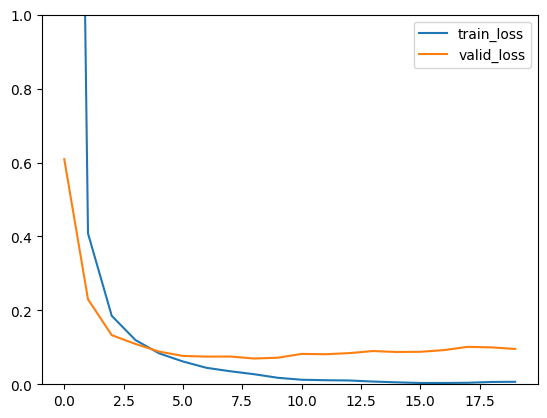

In [57]:
train()

In [27]:
# Recompile model with tensorRT
optimized_model = torch.compile(model, backend='tensorrt')

In [28]:
display(F.to_pil_image(valid_set[1021][0]))

In [31]:
optimized_model(preprocess_trans(valid_set[1028][0]).to(device)).argmax(dim=1).item()

3